# TP4 : Reconnaissance de mots isolés par programmation dynamique (DTW)

NOM - PRÉNOM :
Déposer le notebook sur moodle à la fin de la séance.

In [91]:
import numpy as np
from math import floor, inf, dist, ceil
import scipy.io.wavfile as wav
import os
import matplotlib.pyplot as plt

# Réutilisation de fonctions pour la lecture et la paramétrisation

In [67]:
# Réutiliser la fonction lecture permettant de lire un fichier son et de connaître ses caractéristiques 
# (fréquence d’échantillonnage, durée).

# LECTURE d'un fichier Wave
def lecture(fichier, nb_bits):
    f, signal = wav.read(fichier) # renvoie des signaux reels
    sig_norm = signal / (2**(nb_bits-1)-1) # on normalise les signaux
    return sig_norm, f, len(sig_norm)*1/f

In [68]:
# Réutiliser la fonction parametrisation qui calcule les paramètres acoustiques
# (coefficients cepstraux) d’un fichier sonore sur des fenêtres de taille  "taille_fenetre"  avec un
# recouvrement de moitié.
    
# Calcul de "nbe_coef" coefficients cepstraux
def parametrisation(signal, taille_fenetre, nbe_coef):
    recouvrement = floor(taille_fenetre / 2)
    nb_fen = floor((np.size(signal) - taille_fenetre) / recouvrement) + 1
    mfcc = np.zeros((nb_fen, nbe_coef))

    # Calcul des MFCC
    for fen in range(nb_fen):
        p = fen * recouvrement
        spectre = abs(np.fft.fft(np.multiply(signal[p:p + taille_fenetre], np.hamming(taille_fenetre))))
        cepstre = np.fft.fft(np.log(spectre))
        cc = cepstre[1:nbe_coef+1].real
        mfcc[fen, :] = cc

    return mfcc

In [69]:
# Modifier votre fonction  parametrisation_total (utilisant la fonction  parametrisation )
# afin qu’elle permette de calculer les paramètres pour l’ensemble des fichiers d’un répertoire
# rep_wav  et de stocker les résultats dans un répertoire  rep_mfcc. Cette fonction renvoie
# la liste des noms de fichiers traités.
    
# Fonction de paramétrisation totale --> tous les fichiers du répertoire 'WAV/APP'
def parametrisation_total(nb_bits, taille_fenetre, nbe_coef, rep_wav, rep_mfcc):
    l_nom=[]
    for path in os.listdir(rep_wav):
        if os.path.isfile(os.path.join(rep_wav, path)):
            l_nom.append(path)
            signal, fe, duree = lecture(rep_wav+ path, nb_bits)
            mfcc = parametrisation(signal,taille_fenetre,nbe_coef)
            np.savetxt(rep_mfcc + path[:len(path)-4] + ".mfcc",mfcc)
    return l_nom

# Programmation dynamique

In [156]:
# Ecrire une fonction dtw qui prend deux arguments en entrée : la matrice de coefficients
# cepstraux du signal à reconnaître (observation) et la matrice de coefficients cepstraux d'un
# signal de référence. Cette fonction renvoie le coût normalisé.
    
# Calcul de la DTW entre deux vecteurs
def dtw(mfcc_ref, mfcc_obs):
    size = [len(mfcc_ref[:,0])+1, len(mfcc_obs[:,0])+1]

    g = np.zeros(size)
    d = np.zeros(size)

    #init
    for i in range(1,size[0]):
        g[i,0]=np.inf
        d[i,0]=np.inf
    for j in range(1,size[1]):
        g[0,j]=np.inf
        d[0,j]=np.inf
    g[0,0]=0

    for i in range(1,size[0]):
        x = np.array(mfcc_ref[i-1,:])
        for j in range(1,size[1]):
            y = np.array(mfcc_obs[j-1,:])
            d[i,j] = np.sqrt(np.sum((x-y)**2))

    #boucle
    for i in range(1,size[0]):
        for j in range(1,size[1]):
            premier_min = min(g[i-1,j] + d[i,j],g[i-1,j-1] + 2*d[i,j])
            g[i,j] = min(premier_min,g[i,j-1] + d[i,j])
    #print(g)
    return g[size[0]-1,size[1]-1] / (size[0]+size[1])

In [157]:
#Ecrire une fonction   dtw_total   (utilisant la fonction   dtw  ) qui calcule la DTW sur toutes
# les observations (fichiers Wave) du répertoire   rep_obs   par rapport   toutes les références
# (fichiers MFCC) du répertoire   rep_ref. Cette fonction renvoie une matrice de coûts de taille
# nb_fichier_obs x nb_fichier_ref.

# DTW sur toutes les observations par rapport à toutes les références
def DTW_total(nb_bits, taille_fenetre, nbe_coef, rep_mfcc_ref, rep_wave_obs):
    dw=[]
    for obs in os.listdir(rep_wave_obs):
        sous_dw=[]
        if os.path.isfile(os.path.join(rep_wave_obs, obs)):
            signal, fe, duree = lecture(rep_wave_obs+ obs, nb_bits)
            mfcc_obs = parametrisation(signal,taille_fenetre,nbe_coef)
            for ref in os.listdir(rep_mfcc_ref):
                if os.path.isfile(os.path.join(rep_mfcc_ref, ref)):
                    mfcc_ref = np.loadtxt(rep_mfcc_ref+ref)
                    sous_dw.append(dtw(mfcc_ref,mfcc_obs))
        dw.append(sous_dw)
    return dw

# Affichages et tests

In [158]:
# Ecrire un programme principal qui lance les fonctions précédentes et affiche pour chaque
# observation (mot inconnu), le mot le plus probable.

# Initialisation
q = 16
taille_fenetre = 1024
nbe_coef = 16
rep_ref = 'SIGNAL/REF/'
rep_obs = 'SIGNAL/OBS/'
rep_mfcc = 'MFCC/'


In [159]:
# Paramétrisation des fichiers références
nom_fic_ref = parametrisation_total(q,taille_fenetre,nbe_coef,rep_ref,rep_mfcc)
# Test de la DTW
mat_cout = DTW_total(q,taille_fenetre,nbe_coef,rep_mfcc,rep_obs)
mat_cout = np.array(mat_cout)


In [160]:
# Affichage des couts

s = mat_cout.shape

for i in range(s[0]):
    indice = np.argmin(mat_cout[i])
    print("Le fichier ",nom_fic_ref[i], " est reconnu comme ",nom_fic_ref[indice])

Le fichier  alpha.wav  est reconnu comme  alpha.wav
Le fichier  bravo.wav  est reconnu comme  bravo.wav
Le fichier  charlie.wav  est reconnu comme  mike.wav
Le fichier  delta.wav  est reconnu comme  delta.wav
Le fichier  echo.wav  est reconnu comme  echo.wav
Le fichier  foxtrott.wav  est reconnu comme  foxtrott.wav
Le fichier  golf.wav  est reconnu comme  golf.wav
Le fichier  hotel.wav  est reconnu comme  hotel.wav
Le fichier  india.wav  est reconnu comme  india.wav
Le fichier  juliett.wav  est reconnu comme  juliett.wav
Le fichier  kilo.wav  est reconnu comme  kilo.wav
Le fichier  lima.wav  est reconnu comme  lima.wav
Le fichier  mike.wav  est reconnu comme  mike.wav


['alpha.wav', 'bravo.wav', 'charlie.wav', 'delta.wav', 'echo.wav', 'foxtrott.wav', 'golf.wav', 'hotel.wav', 'india.wav', 'juliett.wav', 'kilo.wav', 'lima.wav', 'mike.wav']


AttributeError: 'AxesSubplot' object has no attribute 'xticks'

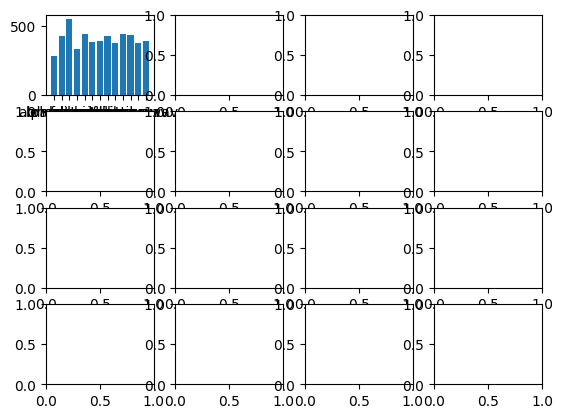

In [162]:
# Affichage amélioré

print(nom_fic_ref)

nb_fic = ceil(np.sqrt(s[0]))
fig, ax = plt.subplots(nrows=nb_fic, ncols=nb_fic)

i=0
for row in ax:
    for col in row:
        col.bar(nom_fic_ref,mat_cout[i])
        i=i+1
        if i >= s[0]:
            break

plt.show()

# Calculer le score de reconnaissance.

# Pour chaque observation, affichage des coûts (par rapport aux références) sous forme d'histogramme



In [3]:
# Affichage score final


In [ ]:
# Autres tests 
# Tests
# Bien  videmment, afin d’am liorer les r sultats, vous pourrez modifier :
# - le nombre de param tres (coefficients cepstraux) : nbe_coef,
# - la taille de la fen tre d’analyse : taille_fenetre,
# ET TESTER AVEC VOS PROPRES ENREGISTREMENTS !